# Helmet Mapping: rotating the NGS frame
Reference: https://www.kaggle.com/its7171/nfl-baseline-simple-helmet-mapping

In [1]:
# # Developer
# %cd /kaggle
# from IPython.display import clear_output
# pat = input('Personal Access Token:')
# clear_output()
# ! git clone https://$pat@github.com/qAp/nfl_helmet_assignment_kaggle.git

# %cd /kaggle/nfl_helmet_assignment_kaggle/
# ! git pull

In [2]:
# User
! cp -r /kaggle/input/nfl-helmet-assignment-kaggle/nfl_helmet_assignment_kaggle /kaggle/.

In [3]:
import os, sys
import importlib
import random
from multiprocessing import Pool
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

sys.path.append('/kaggle/nfl_helmet_assignment_kaggle/')
from helmet_tracker.utils.features import add_track_features
from helmet_tracker.models.helmet_mapping import *
from helmet_tracker.util import create_football_field

In [4]:
# import helmet_tracker
# importlib.reload(helmet_tracker.models.helmet_mapping)

# Setting and loading data

In [5]:
debug = True
CONF_THRE = 0.3
BASE_DIR = '/kaggle/input/nfl-health-and-safety-helmet-assignment/'

labels = pd.read_csv(f'{BASE_DIR}/train_labels.csv')
if debug:
    dir_video = os.path.join(BASE_DIR, 'train')
    tracking = pd.read_csv(f'{BASE_DIR}/train_player_tracking.csv')
    helmets = pd.read_csv(f'{BASE_DIR}/train_baseline_helmets.csv')
else:
    dir_video = os.pth.join(BASE_DIR, 'test')
    tracking = pd.read_csv(f'{BASE_DIR}/test_player_tracking.csv')
    helmets = pd.read_csv(f'{BASE_DIR}/test_baseline_helmets.csv')

In [6]:
%%time

# Add estimated video frame to NGS data

tracking = add_track_features(tracking) 

CPU times: user 1.67 s, sys: 80.5 ms, total: 1.75 s
Wall time: 1.76 s


In [7]:
# Select a couple of examples for debugging.

if debug:
    sample_keys = random.sample(list(tracking['gameKey'].unique()), 3)
    
    helmets['gameKey'] = helmets['video_frame'].str.split('_').str[0]
    
    tracking = tracking[tracking['gameKey'].isin(sample_keys)]
    helmets = helmets[helmets['gameKey'].astype(int).isin(sample_keys)]
    labels = labels[labels['gameKey'].astype(int).isin(sample_keys)]

In [8]:
helmets['video'] = helmets['video_frame'].str.split('_').str[:3].str.join('_')
helmets['frame'] = helmets['video_frame'].str.split('_').str[3].astype(int)

In [9]:
# Select some video and some frame.

video = helmets['video'].unique()[1]
frame = 300

In [10]:
pth_video = os.path.join(dir_video, video + '.mp4')
pth_video

'/kaggle/input/nfl-health-and-safety-helmet-assignment/train/57775_000933_Sideline.mp4'

In [11]:
# Get helmets

df_helmets = helmets.query('video==@video and frame==@frame')

In [12]:
# Get tracking data

gameKey, playID, view = video.split('_')
gameKey = int(gameKey)
playID = int(playID)
df_tracking = tracking.query('gameKey==@gameKey and playID==@playID')
nearest_est_frame = find_nearest(df_tracking['est_frame'].values, frame)
df_tracking = df_tracking.query('est_frame==@nearest_est_frame')

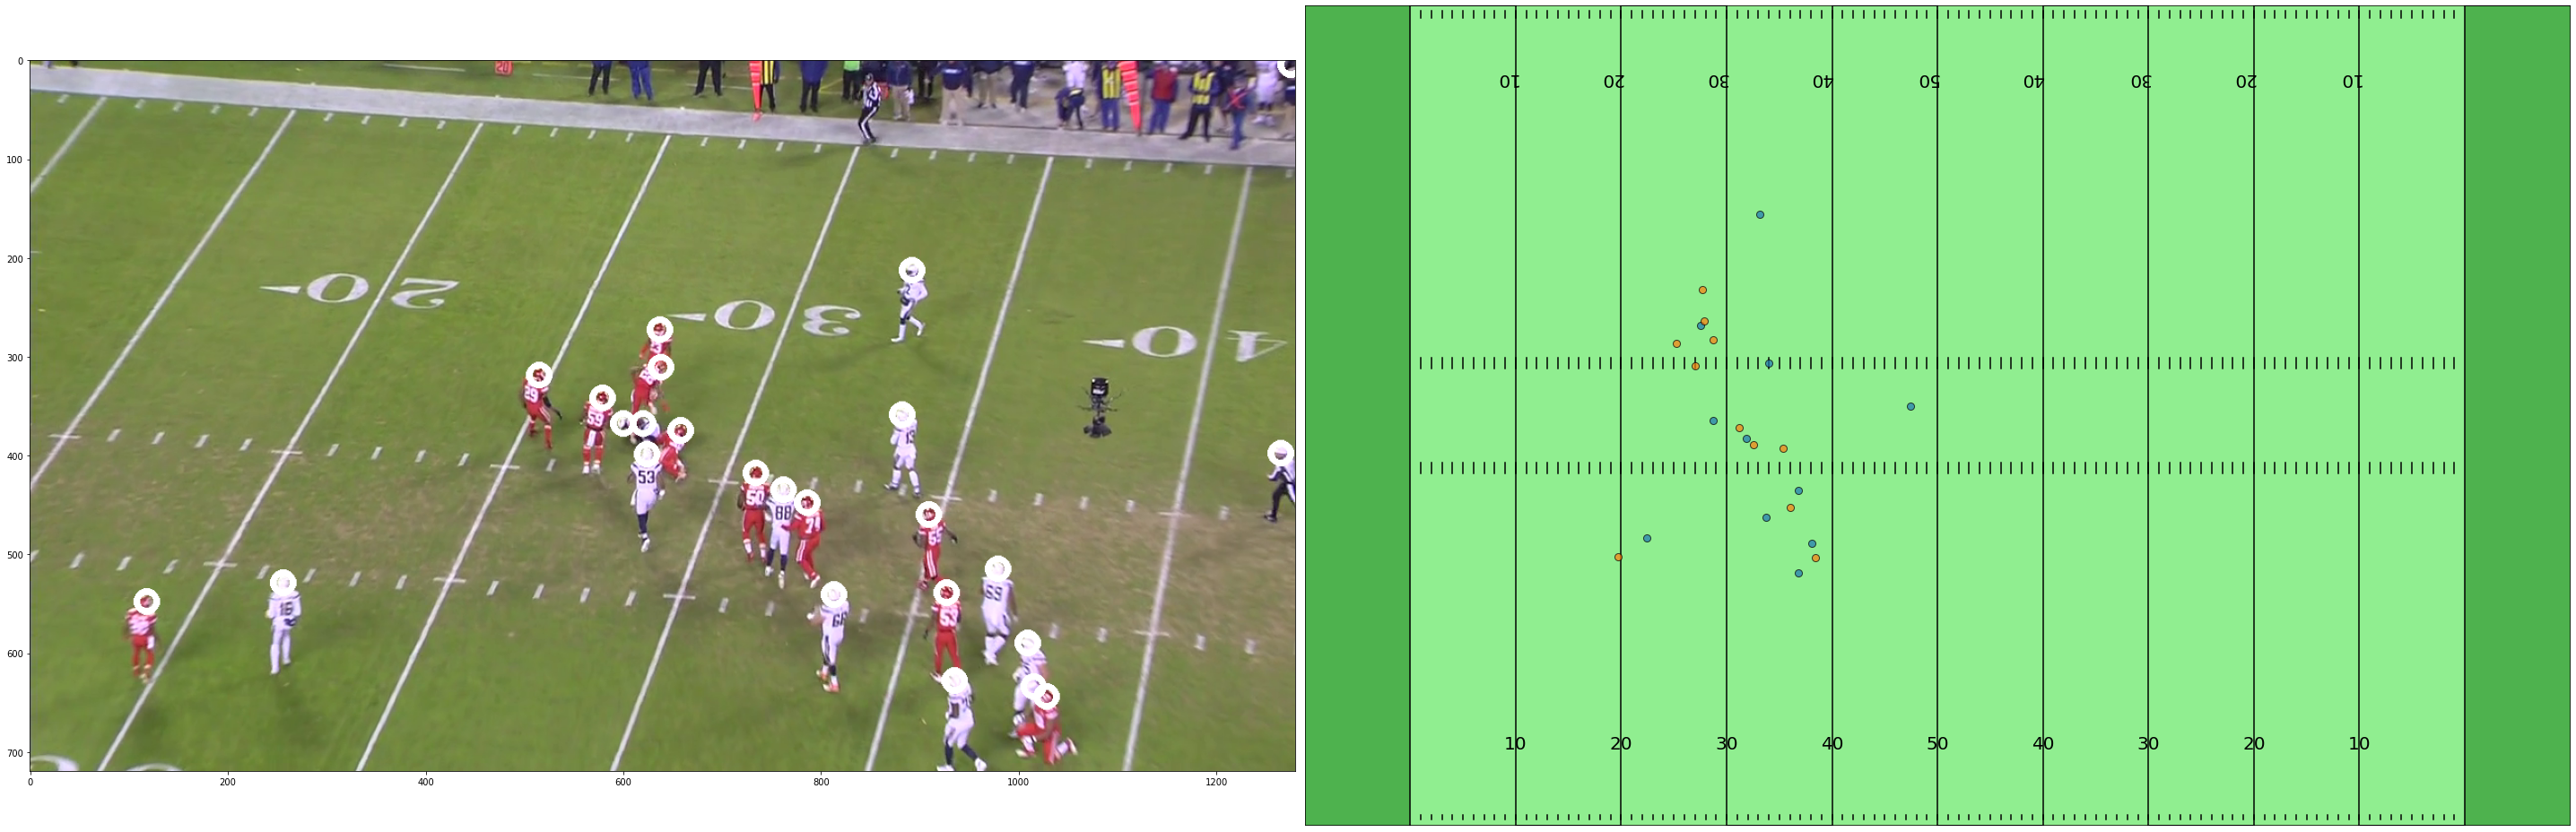

In [13]:
# Plot the two, with NGS positions on whole football field.

cap = cv2.VideoCapture(pth_video)
for _ in range(frame):
    read_ok, img = cap.read()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for box in df_helmets.itertuples():
    img = cv2.circle(img, 
                     center=(
                         int(box.left + 0.5 * box.width), 
                         int(box.top + 0.5 * box.height)
                     ), 
                     radius=10, color=(255, 255, 255), thickness=5, )

_, axs = plt.subplots(figsize=(40, 13), nrows=1, ncols=2)
axs[0].imshow(img);

axs[1] = create_football_field(ax=axs[1])
for team, d in df_tracking.groupby('team'):
    axs[1].scatter(d['x'], d['y'], label=team, 
                   s=65, lw=1, edgecolors='black', zorder=5, alpha=.7)
    
plt.tight_layout()

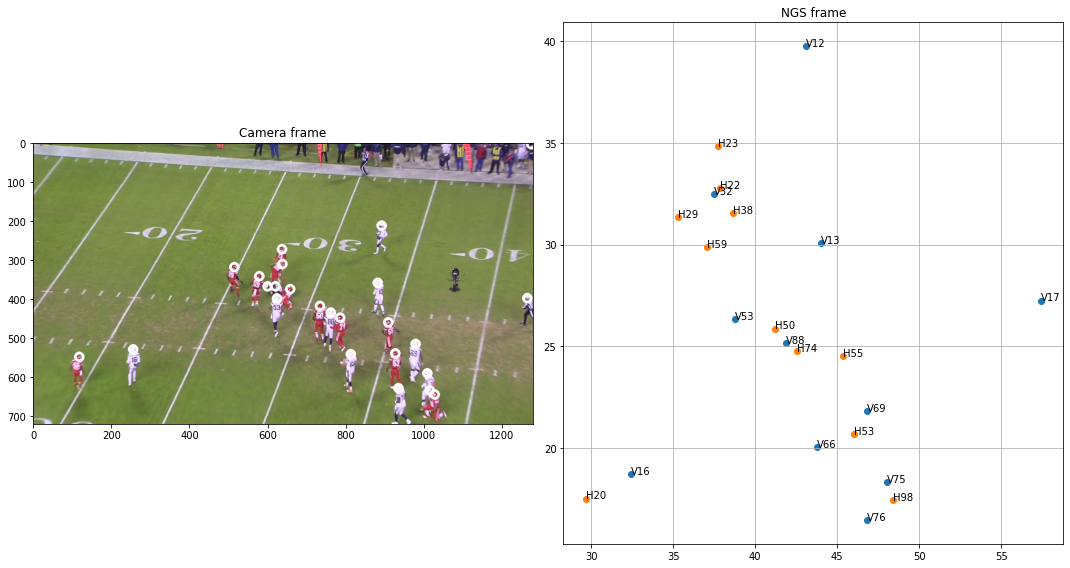

In [14]:
# Don't plot NGS positions on football field.
# Show NGS player numbers explicitly.

_, axs = plt.subplots(figsize=(15, 8), nrows=1, ncols=2)

axs[0].imshow(img)
axs[0].set_title('Camera frame')

for team, d in df_tracking.groupby('team'):
    x, y = d[['x', 'y']].values.T
    axs[1].scatter(x, y, label=team)
    for x_, y_, label in zip(x, y, d['player'].values):
        axs[1].text(x_, y_, label)

axs[1].set_title(f'NGS frame')
axs[1].grid(b=True)

plt.tight_layout();

# Rotating the NGS frame

It can be seen that by rotating the NGS frame, it's possible to adjust its x and y coordinates such that they match up with the x and y coorindates of the helmets in the camera's frame.  

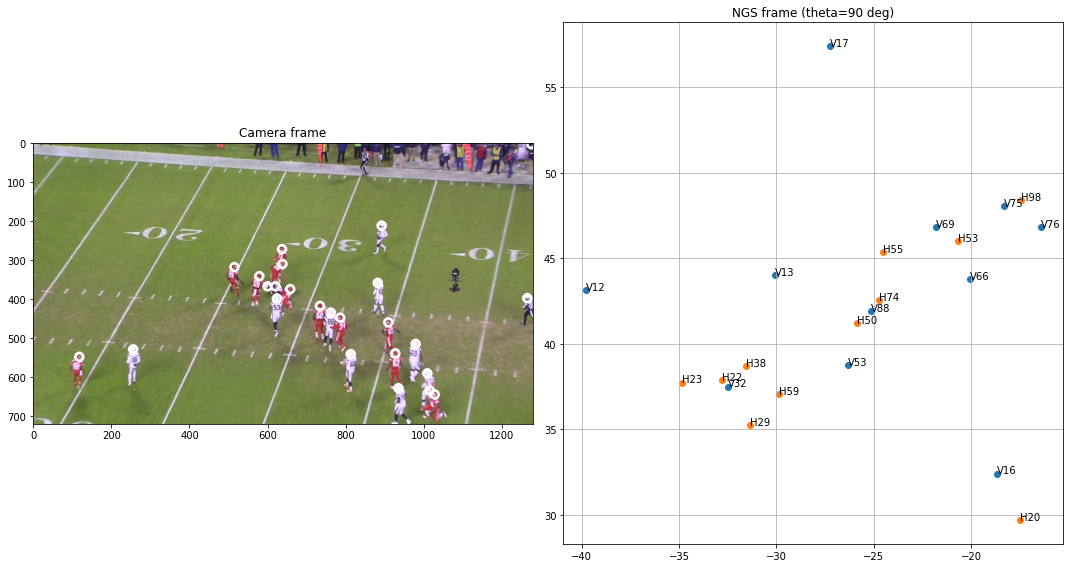

In [15]:
# Rotate NGS frame, then plot and compare with camera frame again.

theta = 90

df_theta = df_tracking.copy()
df_theta['x'], df_theta['y'] = rotate_arr(df_theta[['x', 'y']].values.T, theta)

_, axs = plt.subplots(figsize=(15, 8), nrows=1, ncols=2)

axs[0].imshow(img)
axs[0].set_title('Camera frame')

for team, d in df_theta.groupby('team'):
    axs[1].scatter(d['x'], d['y'], label=team)
    for x, y, player in zip(d['x'], d['y'], d['player']):
        axs[1].text(x, y, player)
    
axs[1].set_title(f'NGS frame (theta={theta} deg)')
axs[1].grid(b=True)

plt.tight_layout();

# Compute closeness of match

After each angle of rotation, compare the NGS positions with the helmet locations.  Do this as follows:
1. Get NGS x-coordinates, sort, then normalise them.
2. Get helmet x-coordinates, sort, then normalise them. 
3. Treat results from 1 and 2 as vectors and compute the absolute difference between them.
4. Repeat steps 1 to 3 for the y-coordinates.
5. Sum the absolute differences from x-coordinates and y-coordinates to get a total difference. 
6. Record this total difference for this angle of rotation.

## No rotation of NGS

In [16]:
# x_ngs = df_tracking['x'].values
# x_ngs = norm_arr(np.sort(x_ngs))
# x_ngs

# x_hel = (df_helmets['left'] + 0.5 * df_helmets['width']).values
# x_hel = norm_arr(np.sort(x_hel))
# x_hel

# len(x_ngs), len(x_hel)

# dx_min, idx_del_x = dist_for_different_len(x_ngs, x_hel)

# dx_min, idx_del_x

In [17]:
# theta = 0

# _, axs = plt.subplots(figsize=(15, 8), nrows=1, ncols=2)

# axs[0].imshow(img)
# axs[0].set_title('Baseline helmets')

# for team, d in df_tracking.groupby('team'):
#     x, y = rotate_arr(d[['x', 'y']].values.T, theta)
#     axs[1].scatter(x, y, label=team)

# df_del = df_tracking.sort_values('x').iloc[list(idx_del_x)]
# axs[1].scatter(df_del['x'].values, df_del['y'].values, 
#                color='black', marker='x')

# axs[1].set_title(f'NGS player coordinates. theta={theta} deg.')
# axs[1].grid(b=True)

# plt.tight_layout();

In [18]:
# y_ngs = df_tracking['y'].values
# y_ngs = norm_arr(np.sort(y_ngs))
# y_ngs

# y_hel = (df_helmets['top'] + 0.5 * df_helmets['height']).values
# y_hel = norm_arr(np.sort(y_hel))
# y_hel

# len(y_ngs), len(y_hel)

# dy_min, idx_del_y = dist_for_different_len(y_ngs, y_hel)

# dy_min, idx_del_y

In [19]:
# theta = 0

# _, axs = plt.subplots(figsize=(15, 8), nrows=1, ncols=2)

# axs[0].imshow(img)
# axs[0].set_title('Baseline helmets')

# for team, d in df_tracking.groupby('team'):
#     x, y = rotate_arr(d[['x', 'y']].values.T, theta)
#     axs[1].scatter(x, y, label=team)

# df_del = df_tracking.sort_values('y').iloc[list(idx_del_y)]
# axs[1].scatter(df_del['x'].values, df_del['y'].values, 
#                color='black', marker='x', s=40)

# axs[1].set_title(f'NGS player coordinates. theta={theta} deg.')
# axs[1].grid(b=True)

# plt.tight_layout();

## NGS rotated by 30 degrees

In [20]:
# theta = 30
# x_ngs, y_ngs = rotate_arr(df_tracking[['x', 'y']].values.T, theta)
# x_ngs = norm_arr(np.sort(x_ngs))
# y_ngs = norm_arr(np.sort(y_ngs))

# dx_min, idx_del_x = dist_for_different_len(x_ngs, x_hel)
# dy_min, idx_del_y = dist_for_different_len(y_ngs, y_hel)
# print(dx_min, idx_del_x)
# print(dy_min, idx_del_y)

In [21]:
# df_theta = df_tracking.copy()
# df_theta['x'], df_theta['y'] = rotate_arr(df_theta[['x', 'y']].values.T, theta)

# _, axs = plt.subplots(figsize=(15, 8), nrows=1, ncols=2)

# axs[0].imshow(img)
# axs[0].set_title('Baseline helmets')

# for team, d in df_theta.groupby('team'):
#     axs[1].scatter(d['x'], d['y'], label=team, zorder=5,)

# df_del = df_theta.sort_values('x').iloc[list(idx_del_x)]
# axs[1].scatter(df_del['x'].values, df_del['y'].values,
#                color='black', marker='x', s=100, zorder=6)

# df_del = df_theta.sort_values('y').iloc[list(idx_del_y)]
# axs[1].scatter(df_del['x'].values, df_del['y'].values, 
#                color='magenta', marker='x', s=100, zorder=6)

# axs[1].set_title(f'NGS player coordinates. theta={theta} deg.')
# axs[1].grid(b=True)

# plt.tight_layout();

In [22]:
# dtheta = 30
# thetas = np.arange(dtheta, 360, dtheta)
# thetas